In [1]:
import BMTextTokenizer as bmt
import pandas as pd
import networkx as nx
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sample = 'Analyses of dynamic light scattering data by stretched exponential fit show that vinculin has a negligible influence on internal actin filament dynamics and actin bending stiffness which contrasts with our previous observations with talin, another actin and vinculin-binding protein from focal adhesions.'


To a human reader, the understanding would be 'vinculin' has negligible influence on 'actin' related characteristics, which is different from 'talin'-related behaviour.

The reason is the phrase <b>'negligible influence'</b> between 'vinculin' and 'actin' indicates there is <b>NO</b> interaction between two while the previous observations between 'vinculin' and 'talin' <b>contrasts</b> with such.

So I am doing here is develop a way to uncover this heuristic using machine learning model.

### Analyse the Sentence Structure based on Stanza's Tokenized Output

<b>Approach 1:</b> Using stanza's tokenizer instead of providing my own pretokenized sentence as input

In [3]:
import stanza
nlp = stanza.Pipeline(lang='en', package='craft', processor='tokenize,pos')

2022-01-20 09:40:54 INFO: Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | craft   |
| pos       | craft   |
| lemma     | craft   |
| depparse  | craft   |

2022-01-20 09:40:54 INFO: Use device: cpu
2022-01-20 09:40:54 INFO: Loading: tokenize
2022-01-20 09:40:54 INFO: Loading: pos
2022-01-20 09:40:54 INFO: Loading: lemma
2022-01-20 09:40:54 INFO: Loading: depparse
2022-01-20 09:40:54 INFO: Done loading processors!


In [4]:
doc = nlp(sample)

In [5]:
print(*[f'id: {word.id}\tword: {word.text.ljust(25, " ")}\tupos: {word.upos.ljust(6, " ")}\thead: {sent.words[word.head-1].text.ljust(25, " ") if word.head > 0 else "root"}\tdeprel: {word.deprel}' for sent in doc.sentences for word in sent.words], sep='\n')


id: 1	word: Analyses                 	upos: NOUN  	head: show                     	deprel: nsubj
id: 2	word: of                       	upos: ADP   	head: data                     	deprel: case
id: 3	word: dynamic                  	upos: ADJ   	head: data                     	deprel: amod
id: 4	word: light                    	upos: NOUN  	head: data                     	deprel: compound
id: 5	word: scattering               	upos: NOUN  	head: data                     	deprel: compound
id: 6	word: data                     	upos: NOUN  	head: Analyses                 	deprel: nmod
id: 7	word: by                       	upos: ADP   	head: fit                      	deprel: case
id: 8	word: stretched                	upos: VERB  	head: fit                      	deprel: amod
id: 9	word: exponential              	upos: ADJ   	head: fit                      	deprel: amod
id: 10	word: fit                      	upos: NOUN  	head: Analyses                 	deprel: nmod
id: 11	word: show             

In [6]:
%time
G = nx.Graph() # using undirected graph to establish a baseline behavior
for sent in doc.sentences:
    for word in sent.words:
        head = word.text
        tail = sent.words[word.head-1].text
        if word.upos == 'PUNCT' or sent.words[word.head-1].upos=='PUNCT':
            pass
        else:
            
            G.add_node(head, pos=word.upos, deprel=word.deprel)
            G.add_node(tail, pos=sent.words[word.head-1].upos, deprel=sent.words[word.head-1].deprel)
            G.add_edge(head, tail, weight=1)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 11 µs


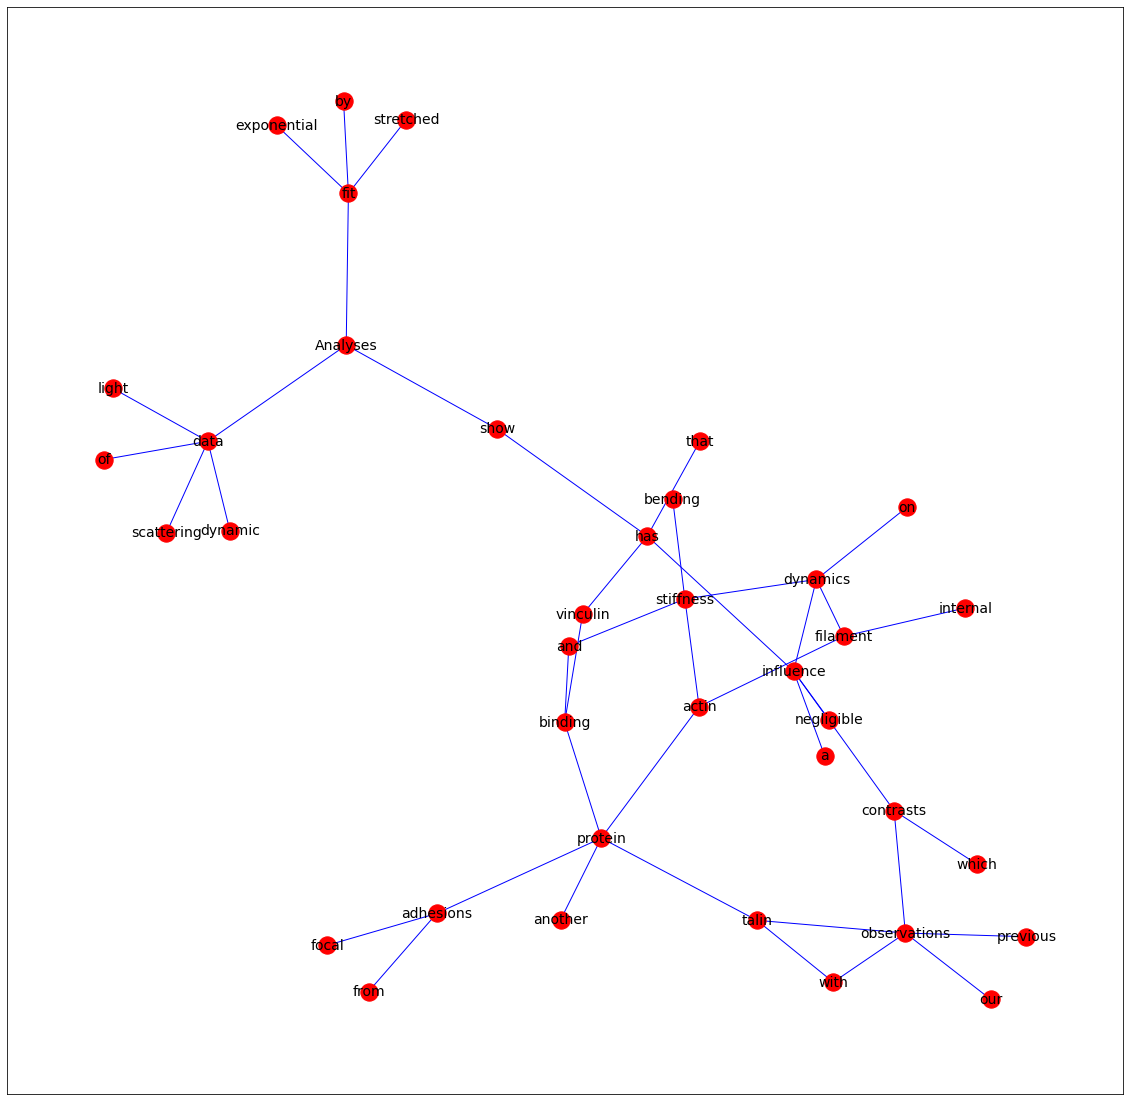

In [7]:
bmt.plot_network(G)

In [8]:
# Let's examine if 'actin', 'talin', and 'vinculin' exist as distinct nodes
entities = ['actin','talin','vinculin']
nodes = G.nodes()
atoms = []
for node in nodes:
    for entity in entities:
        if entity in node:
            atoms.append(node)
atoms

['vinculin', 'actin', 'talin']

In [9]:
from itertools import permutations
tuples = permutations(atoms, 2)
for t in tuples:
    print (t)

('vinculin', 'actin')
('vinculin', 'talin')
('actin', 'vinculin')
('actin', 'talin')
('talin', 'vinculin')
('talin', 'actin')


In [10]:
%time
tuples = permutations(atoms, 2)
simple_path = []
for t in tuples:
    #print (t)
    paths = list(nx.all_simple_paths(G, source=t[0], target=t[1]))
    for p in paths:
        #print (p)
        simple_path.append(p)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 11 µs


In [11]:
for index, p in enumerate(simple_path):
    print (index, ':', p)

0 : ['vinculin', 'has', 'influence', 'dynamics', 'filament', 'actin']
1 : ['vinculin', 'has', 'influence', 'dynamics', 'stiffness', 'and', 'binding', 'protein', 'actin']
2 : ['vinculin', 'has', 'influence', 'dynamics', 'stiffness', 'actin']
3 : ['vinculin', 'has', 'influence', 'contrasts', 'observations', 'with', 'talin', 'protein', 'actin']
4 : ['vinculin', 'has', 'influence', 'contrasts', 'observations', 'with', 'talin', 'protein', 'binding', 'and', 'stiffness', 'actin']
5 : ['vinculin', 'has', 'influence', 'contrasts', 'observations', 'with', 'talin', 'protein', 'binding', 'and', 'stiffness', 'dynamics', 'filament', 'actin']
6 : ['vinculin', 'has', 'influence', 'contrasts', 'observations', 'talin', 'protein', 'actin']
7 : ['vinculin', 'has', 'influence', 'contrasts', 'observations', 'talin', 'protein', 'binding', 'and', 'stiffness', 'actin']
8 : ['vinculin', 'has', 'influence', 'contrasts', 'observations', 'talin', 'protein', 'binding', 'and', 'stiffness', 'dynamics', 'filament', 'a

From above simple paths, the relationship among those entities seems to be obscure to establish even there are over 100 ways to <b>'connect'</b> any two assigned entities.

<b>Approach 2:</b> Using pretokenized sentence as input

In [12]:
pretokenized_nlp = stanza.Pipeline(lang='en', package='craft', processor='tokenize', tokenize_pretokenized=True)

2022-01-20 09:52:01 INFO: Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | craft   |
| pos       | craft   |
| lemma     | craft   |
| depparse  | craft   |

2022-01-20 09:52:01 INFO: Use device: cpu
2022-01-20 09:52:01 INFO: Loading: tokenize
2022-01-20 09:52:01 INFO: Loading: pos
2022-01-20 09:52:01 INFO: Loading: lemma
2022-01-20 09:52:01 INFO: Loading: depparse
2022-01-20 09:52:01 INFO: Done loading processors!


In [13]:
doc_re = bmt.tokenizer(pretokenized_nlp, sample)

In [14]:
print(*[f'id: {word.id}\tword: {word.text.ljust(25, " ")}\tupos: {word.upos.ljust(6, " ")}\thead: {sent.words[word.head-1].text.ljust(25, " ") if word.head > 0 else "root"}\tdeprel: {word.deprel}' for sent in doc_re.sentences for word in sent.words], sep='\n')


id: 1	word: Analyses                 	upos: NOUN  	head: show                     	deprel: nsubj
id: 2	word: of                       	upos: ADP   	head: dynamic light scattering data	deprel: case
id: 3	word: dynamic light scattering data	upos: NOUN  	head: Analyses                 	deprel: nmod
id: 4	word: by                       	upos: ADP   	head: stretched exponential fit	deprel: case
id: 5	word: stretched exponential fit	upos: NOUN  	head: Analyses                 	deprel: nmod
id: 6	word: show                     	upos: VERB  	head: root	deprel: root
id: 7	word: that                     	upos: SCONJ 	head: has                      	deprel: mark
id: 8	word: vinculin                 	upos: NOUN  	head: has                      	deprel: nsubj
id: 9	word: has                      	upos: VERB  	head: show                     	deprel: ccomp
id: 10	word: a                        	upos: DET   	head: negligible influence     	deprel: det
id: 11	word: negligible influence     	upos: NOUN 

In [15]:
%time
H = nx.Graph() # using undirected graph to establish a baseline behavior
for sent in doc_re.sentences:
    for word in sent.words:
        head = word.text
        tail = sent.words[word.head-1].text
        if word.upos == 'PUNCT' or sent.words[word.head-1].upos=='PUNCT':
            pass
        else:
            
            H.add_node(head, pos=word.upos, deprel=word.deprel)
            H.add_node(tail, pos=sent.words[word.head-1].upos, deprel=sent.words[word.head-1].deprel)
            H.add_edge(head, tail, weight=1)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 11 µs


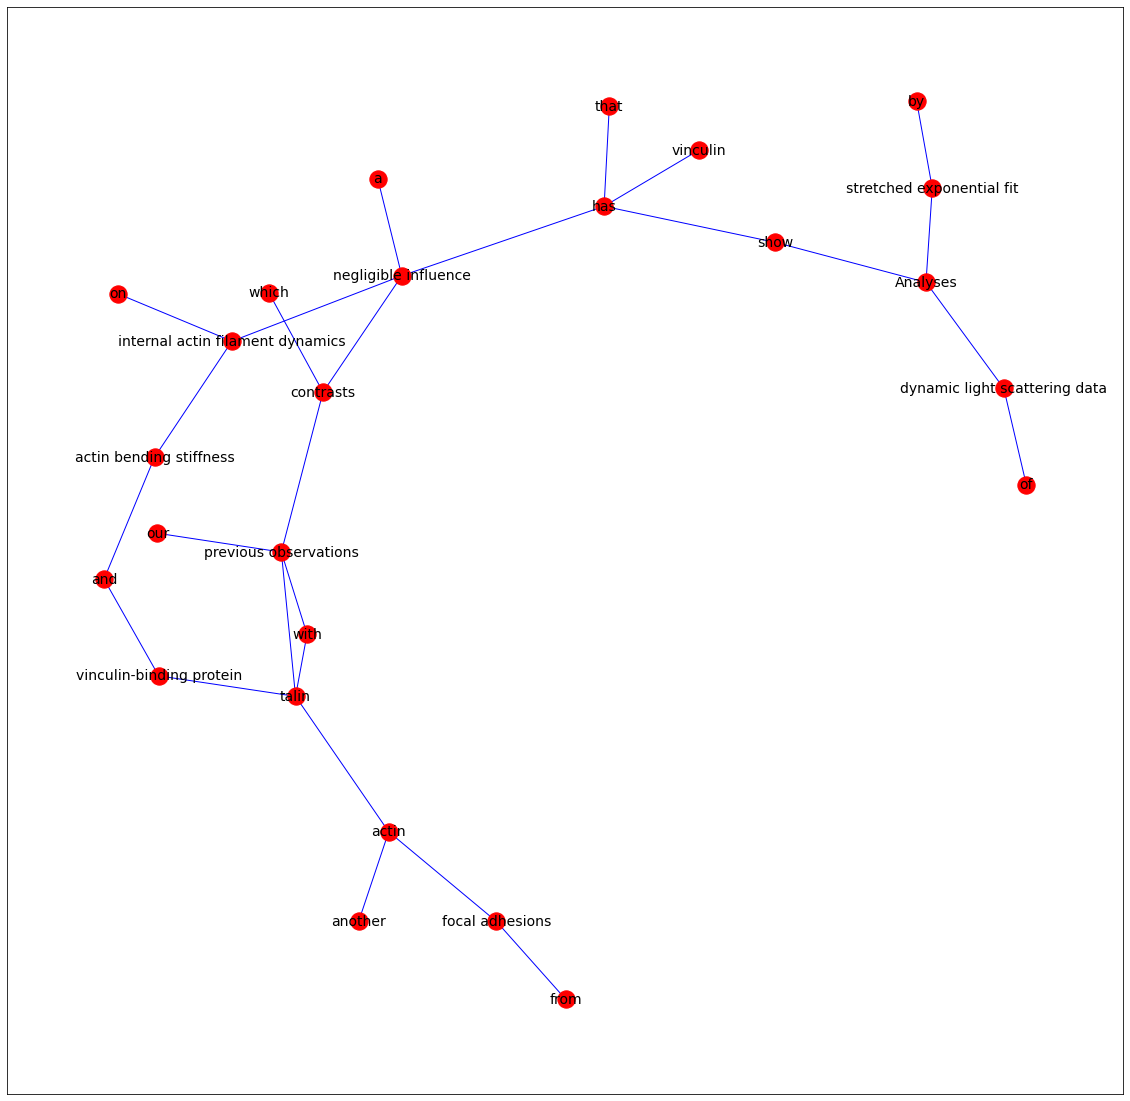

In [16]:
bmt.plot_network(H)

In [17]:
# Let's examine if 'actin', 'talin', and 'vinculin' exist as distinct nodes
entities = ['actin','talin','vinculin']
nodes = H.nodes()
atoms = []
for node in nodes:
    for entity in entities:
        if entity in node:
            atoms.append(node)
atoms

['vinculin',
 'internal actin filament dynamics',
 'actin bending stiffness',
 'talin',
 'actin',
 'vinculin-binding protein']

In [18]:
%time
tuples = permutations(atoms, 2)
simple_path = []
for t in tuples:
    #print (t)
    paths = list(nx.all_simple_paths(H, source=t[0], target=t[1]))
    for p in paths:
        #print (p)
        simple_path.append(p)

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 12.2 µs


In [19]:
for index, p in enumerate(simple_path):
    print (index, ':', p)

0 : ['vinculin', 'has', 'negligible influence', 'internal actin filament dynamics']
1 : ['vinculin', 'has', 'negligible influence', 'contrasts', 'previous observations', 'with', 'talin', 'vinculin-binding protein', 'and', 'actin bending stiffness', 'internal actin filament dynamics']
2 : ['vinculin', 'has', 'negligible influence', 'contrasts', 'previous observations', 'talin', 'vinculin-binding protein', 'and', 'actin bending stiffness', 'internal actin filament dynamics']
3 : ['vinculin', 'has', 'negligible influence', 'internal actin filament dynamics', 'actin bending stiffness']
4 : ['vinculin', 'has', 'negligible influence', 'contrasts', 'previous observations', 'with', 'talin', 'vinculin-binding protein', 'and', 'actin bending stiffness']
5 : ['vinculin', 'has', 'negligible influence', 'contrasts', 'previous observations', 'talin', 'vinculin-binding protein', 'and', 'actin bending stiffness']
6 : ['vinculin', 'has', 'negligible influence', 'internal actin filament dynamics', 'acti

From above simple paths, they seems to make better sense among those entities of interest.  However, it still looks obscure on the 'direction' of the influence.

<b>Approach 3:</b> Using stanza's tokenizer instead of providing my own pretokenized sentence as input to create a Directed Graph

In [20]:
%time
I = nx.DiGraph() # using directed graph to compare with undirected Graph
for sent in doc.sentences:
    for word in sent.words:
        head = word.text
        tail = sent.words[word.head-1].text
        if word.upos == 'PUNCT' or sent.words[word.head-1].upos=='PUNCT':
            pass
        else:
            
            I.add_node(head, pos=word.upos, deprel=word.deprel)
            I.add_node(tail, pos=sent.words[word.head-1].upos, deprel=sent.words[word.head-1].deprel)
            I.add_edge(head, tail, weight=1)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10 µs


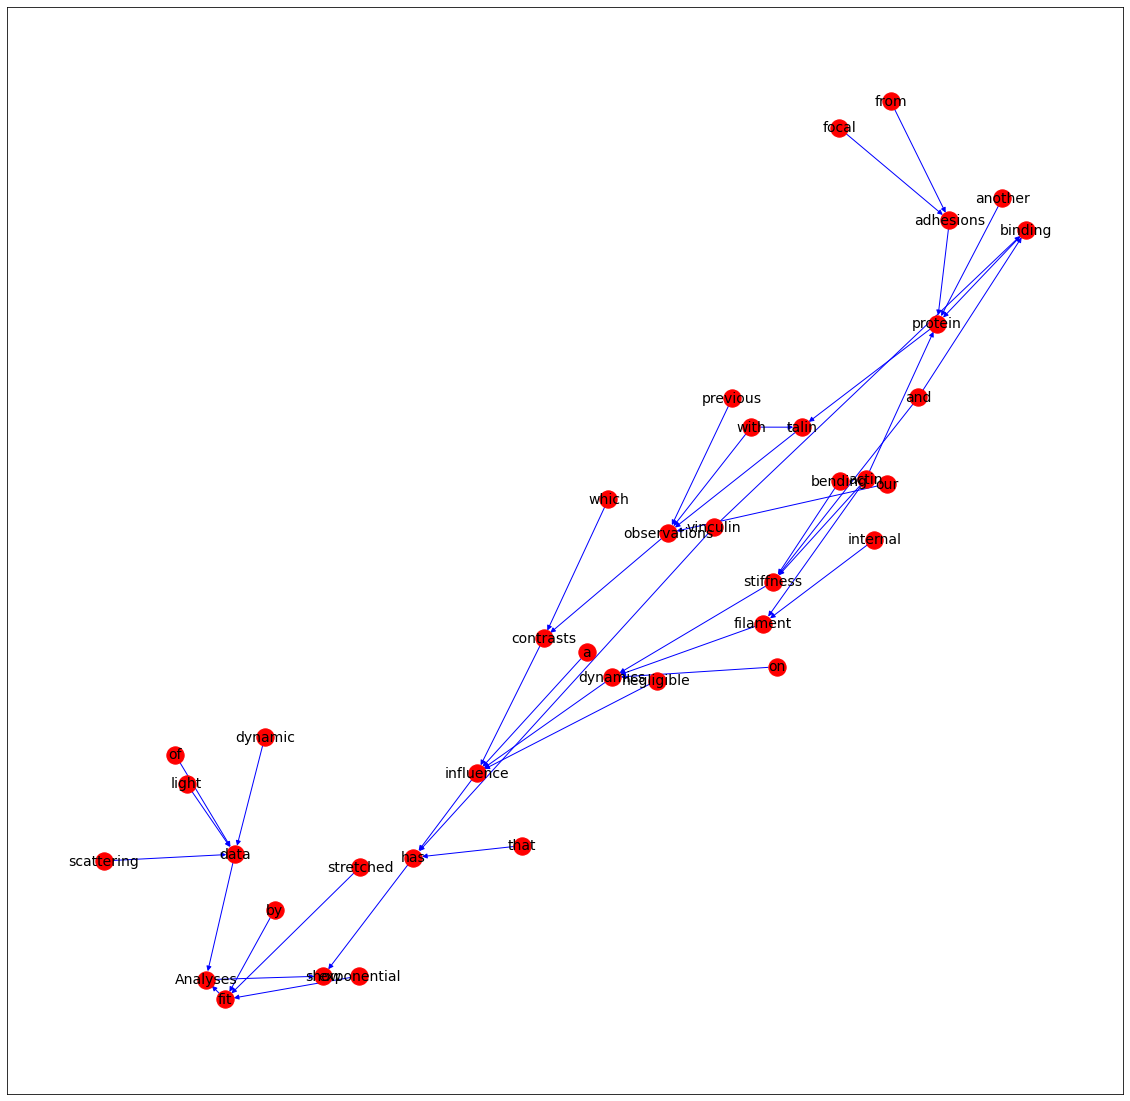

In [21]:
bmt.plot_network(I)

In [22]:
entities = ['actin','talin','vinculin']
nodes = I.nodes()
atoms = []
for node in nodes:
    for entity in entities:
        if entity in node:
            atoms.append(node)
atoms

['vinculin', 'actin', 'talin']

In [23]:
from itertools import permutations
tuples = permutations(atoms, 2)
for t in tuples:
    print (t)

('vinculin', 'actin')
('vinculin', 'talin')
('actin', 'vinculin')
('actin', 'talin')
('talin', 'vinculin')
('talin', 'actin')


In [24]:
%time
tuples = permutations(atoms, 2)
simple_path = []
for t in tuples:
    #print (t)
    paths = list(nx.all_simple_paths(I, source=t[0], target=t[1]))
    for p in paths:
        #print (p)
        simple_path.append(p)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 13.8 µs


In [25]:
for index, p in enumerate(simple_path):
    print (index, ':', p)

0 : ['vinculin', 'binding', 'protein', 'talin']
1 : ['actin', 'protein', 'talin']


From above simple paths, Directed Graph constructed from tokens parsed by default stanza processer simply erases any evidence that three entities are connected in any meaningful way

<b>Approach 4:</b> Using my own pretokenized sentence as input to create a Directed Graph

In [26]:
%time
J = nx.DiGraph() # using directed graph to compare with undirected Graph
for sent in doc_re.sentences:
    for word in sent.words:
        head = word.text
        tail = sent.words[word.head-1].text
        if word.upos == 'PUNCT' or sent.words[word.head-1].upos=='PUNCT':
            pass
        else:
            J.add_node(head, pos=word.upos, deprel=word.deprel)
            J.add_node(tail, pos=sent.words[word.head-1].upos, deprel=sent.words[word.head-1].deprel)
            J.add_edge(head, tail, weight=1)

CPU times: user 4 µs, sys: 2 µs, total: 6 µs
Wall time: 14.1 µs


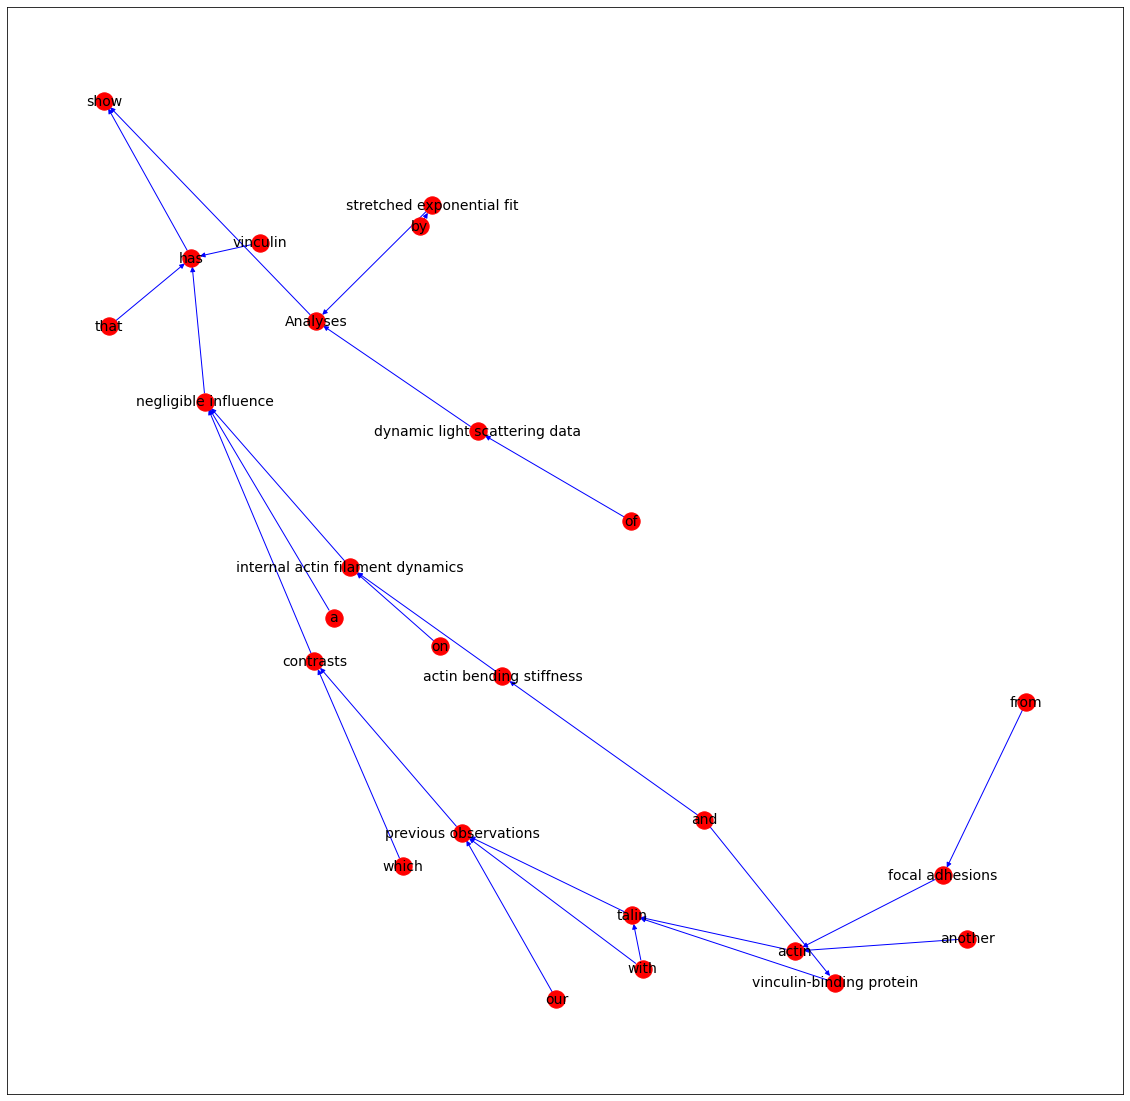

In [27]:
bmt.plot_network(J)

In [28]:
entities = ['actin','talin','vinculin']
nodes = J.nodes()
atoms = []
for node in nodes:
    for entity in entities:
        if entity in node:
            atoms.append(node)
atoms

['vinculin',
 'internal actin filament dynamics',
 'actin bending stiffness',
 'talin',
 'actin',
 'vinculin-binding protein']

In [29]:
from itertools import permutations
tuples = permutations(atoms, 2)
for t in tuples:
    print (t)

('vinculin', 'internal actin filament dynamics')
('vinculin', 'actin bending stiffness')
('vinculin', 'talin')
('vinculin', 'actin')
('vinculin', 'vinculin-binding protein')
('internal actin filament dynamics', 'vinculin')
('internal actin filament dynamics', 'actin bending stiffness')
('internal actin filament dynamics', 'talin')
('internal actin filament dynamics', 'actin')
('internal actin filament dynamics', 'vinculin-binding protein')
('actin bending stiffness', 'vinculin')
('actin bending stiffness', 'internal actin filament dynamics')
('actin bending stiffness', 'talin')
('actin bending stiffness', 'actin')
('actin bending stiffness', 'vinculin-binding protein')
('talin', 'vinculin')
('talin', 'internal actin filament dynamics')
('talin', 'actin bending stiffness')
('talin', 'actin')
('talin', 'vinculin-binding protein')
('actin', 'vinculin')
('actin', 'internal actin filament dynamics')
('actin', 'actin bending stiffness')
('actin', 'talin')
('actin', 'vinculin-binding protein'

In [31]:
%time
tuples = permutations(atoms, 2)
simple_path = []
for t in tuples:
    #print (t)
    paths = list(nx.all_simple_paths(J, source=t[0], target=t[1]))
    for p in paths:
        #print (p)
        simple_path.append(p)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 10 µs


In [32]:
for index, p in enumerate(simple_path):
    print (index, ':', p)

0 : ['actin bending stiffness', 'internal actin filament dynamics']
1 : ['actin', 'talin']
2 : ['vinculin-binding protein', 'talin']


### Findings

1. Retokenized text according to some simple rules like combining tokens with POS tags 'ADJ', 'NOUN', and "VERB' would help improve the extraction of meaning.
2. Directed Graph to model the dependency relationship seems to retrict the expression of the underlying relationship between tokens.

### Next Step

A more in-depth analysis on sentence structure using retokenized text and simple undirected graph presentation.

I will use a bigger data set to see if there is any statistical significance of the underlying graph structure that would help identify sentence with relationship of interest.